# JAXFIT Quickstart

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dipolar-Quantum-Gases/jaxfit/blob/main/docs/source/notebooks/JAXFit%20Quickstart.ipynb)

## Installing and Importing

Make sure your runtime type is set to GPU rather than CPU. Then we install JAXFit with pip

In [1]:
!pip install jaxfit 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import JAXFit before importing JAX since we need JAXFit to set all the JAX computation to use 64 rather than 32 bit arrays.

In [2]:
from jaxfit import CurveFit
import jax.numpy as jnp

Now let's define a 2D Gaussian using jax.numpy. You can construct function just like numpy with a few small caveats (see [current gotchas](https://github.com/Dipolar-Quantum-Gases/jaxfit#current-gotchas)).

In [3]:
def linear(x, m, b):
  return m * x + b

Using the function we just created, we'll simulate some synthetic fit data and show what it looks like.

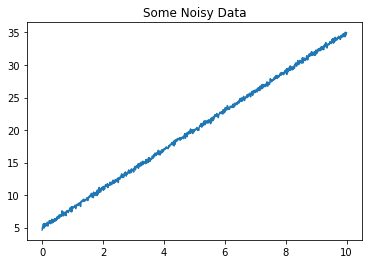

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# make the synthetic data
length = 1000
x = np.linspace(0, 10, length)
params = (3, 5)
y = linear(x, *params) 
# add a little noise to the data to make things interesting
y += np.random.normal(0, 0.2, size=length)

plt.figure()
plt.title('Some Noisy Data')
plt.plot(x, y)
plt.show()

Now let's use JAXFit to fit this data

In [5]:
jcf = CurveFit()
popt, pcov = jcf.curve_fit(linear, x, y, p0=(1,1))
y_fit = linear(x, *popt) 

print('Actual Parameters', params)
print('Fit Parameters', popt)

Actual Parameters (3, 5)
Fit Parameters [2.99789564 5.00665804]


Now we'll take a look at JAXFit's speed. We do the same fit as above with $3\times 10^5$ data points for twenty different sets of data and plot the speed for each of these fits.

Text(0, 0.5, 'Fit Time (seconds)')

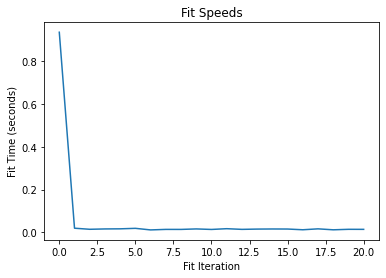

In [6]:
from scipy.optimize import curve_fit
import time

def get_random_parameters(mmin=1, mmax=10, bmin=0, bmax=10):
  deltam = mmax - mmin
  deltab = bmax - bmin
  m = mmin + deltam * np.random.random()
  b = bmin + deltab * np.random.random()
  return m, b
  
  
length = 3 * 10**5
x = np.linspace(0, 10, length)

jcf = CurveFit()
jax_fit_times = []
scipy_fit_times = []
nsamples = 21
for i in range(nsamples):
  params = get_random_parameters()
  y = linear(x, *params) + np.random.normal(0, 0.2, size=length)

  # fit the data
  start_time = time.time()
  popt1, pcov1 = jcf.curve_fit(linear, x, y, p0=(1,1))
  jax_fit_times.append(time.time() - start_time)

plt.figure()
plt.title('Fit Speeds')
plt.plot(jax_fit_times, label='JAXFit')
plt.xlabel('Fit Iteration')
plt.ylabel('Fit Time (seconds)')

As you can see, the first fit is quite slow as JAX is tracing all the functions in the JAXFit CurveFit object behind the scenes. However, after it has traced them once then it runs extremely quickly. 

## Varying Fit Data Array Size

What happens if we change the size of the data for each of these random fits though. Here we increase the data size from $10^3$ to $10^6$ and look at the fit speed.

Summed Fit Times 17.004757165908813


Text(0, 0.5, 'Fit Time (seconds)')

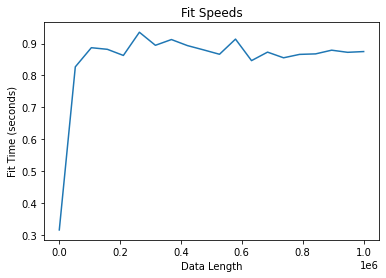

In [7]:
def get_coordinates(length, xmin=0, xmax=10):
  return np.linspace(xmin, xmax, length)


def get_random_data(length):
  xdata = get_coordinates(length)
  params = get_random_parameters()
  ydata = linear(xdata, *params) + np.random.normal(0, 0.2)
  return xdata, ydata


lmin = 10**3
lmax = 10**6
nlengths = 20
lengths = np.linspace(lmin, lmax, nlengths, dtype=int)

jcf = CurveFit()
jax_fit_times = []
for length in lengths:
  xdata, ydata = get_random_data(length)

  start_time = time.time()
  popt1, pcov1 = jcf.curve_fit(linear, xdata, ydata, p0=(1,1))
  jax_fit_times.append(time.time() - start_time)

print('Summed Fit Times', np.sum(jax_fit_times))

plt.figure()
plt.title('Fit Speeds')
plt.plot(lengths, jax_fit_times, label='JAXFit')
plt.xlabel('Data Length')
plt.ylabel('Fit Time (seconds)')

The fit speed is slow for every fit. This is because JAX must retrace a function whenever the size of the input array changes. However, JAXFit has a clever way of getting around this. We set a fixed data size (which should be greater than or equal to the largest data we'll fit) and then we use dummy data behind the scenes to keep the array sizes fixed.

We do the same fits as above, but this time we set a fixed array size length when we instantiate the CurveFit object.

Summed Fit Times 1.214690923690796


Text(0, 0.5, 'Fit Time (seconds)')

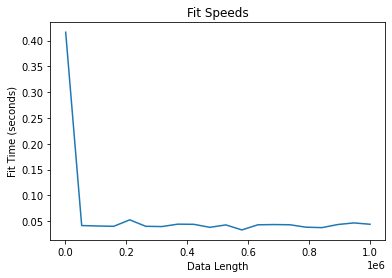

In [8]:
fixed_length = np.amax(lengths)
jcf = CurveFit(flength=fixed_length)

jax_fit_times = []
for length in lengths:
  xdata, ydata = get_random_data(length)

  start_time = time.time()
  popt1, pcov1 = jcf.curve_fit(linear, xdata, ydata, p0=(1,1))
  jax_fit_times.append(time.time() - start_time)

print('Summed Fit Times', np.sum(jax_fit_times))

plt.figure()
plt.title('Fit Speeds')
plt.plot(lengths, jax_fit_times, label='JAXFit')
plt.xlabel('Data Length')
plt.ylabel('Fit Time (seconds)')

Our fits now run extremely fast irrespective of the datasize. There is a slight caveat to this in that the speed of the fits is always that of the fixed data size even if our actual data is smaller. 

If you have two drastically different data sizes in your analysis however, you can instantiate two different CurveFit objects to get an overall fit speedup.

Text(0, 0.5, 'Fit Time (seconds)')

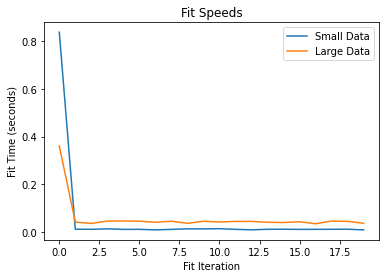

In [9]:
lmin = 10**3
lmax = 10**6
nlengths = 20
lengths1 = np.linspace(10**3, 5 * 10**4, nlengths, dtype=int)
lengths2 = np.linspace(10**5, 10**6, nlengths, dtype=int)

fixed_length1 = np.amax(lengths1)
fixed_length2 = np.amax(lengths2)

jcf1 = CurveFit(flength=fixed_length1)
jcf2 = CurveFit(flength=fixed_length2)

jax_fit_times1 = []
jax_fit_times2 = []

for length1, length2 in zip(lengths1, lengths2):
  xdata1, ydata1 = get_random_data(length1)
  xdata2, ydata2 = get_random_data(length2)

  start_time = time.time()
  popt1, pcov1 = jcf1.curve_fit(linear, xdata1, ydata1, p0=(1,1))
  jax_fit_times1.append(time.time() - start_time)

  start_time = time.time()
  popt2, pcov2 = jcf2.curve_fit(linear, xdata2, ydata2, p0=(1,1))
  jax_fit_times2.append(time.time() - start_time)

plt.figure()
plt.title('Fit Speeds')
plt.plot(jax_fit_times1, label='Small Data')
plt.plot(jax_fit_times2, label='Large Data')
plt.legend()

plt.xlabel('Fit Iteration')
plt.ylabel('Fit Time (seconds)')

## Fitting Multiple Functions 

It's important to instantiate a CurveFit object for each different function you're fitting as well to avoid JAX needing to retrace any underlying functions. First we show what happens if we use the same CurveFit object for two functions.

Summed Fit Times 8.365868330001831


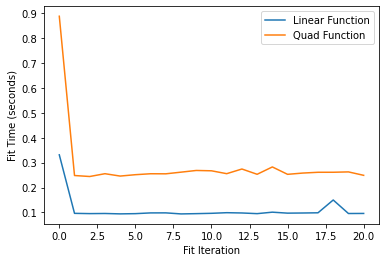

In [10]:
import jax.numpy as jnp

def quad_exp(x, a, b, c, d):
  return a * x**2 + b * x + c + jnp.exp(d)

length = 3 * 10**5
x = np.linspace(0, 10, length)

jcf = CurveFit()
nsamples = 21

all_linear_params = np.random.random(size=(nsamples, 2))
all_quad_params = np.random.random(size=(nsamples, 4))

linear_fit_times = []
quad_fit_times = []
for i in range(nsamples):
  y_linear = linear(x, *all_linear_params[i]) + np.random.normal(0, 0.2, size=length)
  y_quad = quad_exp(x, *all_quad_params[i]) + np.random.normal(0, 0.2, size=length)

  # fit the data
  start_time = time.time()
  popt1, pcov1 = jcf.curve_fit(linear, x, y_linear, p0=(.5,.5,))
  linear_fit_times.append(time.time() - start_time)

  start_time = time.time()
  popt2, pcov2 = jcf.curve_fit(quad_exp, x, y_quad, p0=(.5,.5,.5,.5))
  quad_fit_times.append(time.time() - start_time)

print('Summed Fit Times', np.sum(linear_fit_times + quad_fit_times))

plt.figure()
plt.plot(linear_fit_times, label='Linear Function')
plt.plot(quad_fit_times, label='Quad Function')
plt.xlabel('Fit Iteration')
plt.ylabel('Fit Time (seconds)')
plt.legend()
plt.show()

And we see that by using the same fit object retracing is occuring for every fit. Now we instantiate two separate CurveFit objects for the two functions.

Summed Fit Times 1.8181967735290527


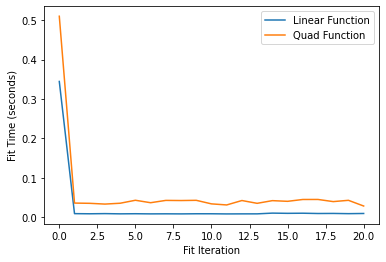

In [11]:
jcf_linear = CurveFit()
jcf_quad = CurveFit()


linear_fit_times = []
quad_fit_times = []
for i in range(nsamples):

  y_linear = linear(x, *all_linear_params[i]) + np.random.normal(0, 0.2, size=length)
  y_quad = quad_exp(x, *all_quad_params[i]) + np.random.normal(0, 0.2, size=length)

  # fit the data
  start_time = time.time()
  popt1, pcov1 = jcf_linear.curve_fit(linear, x, y_linear, p0=(.5,.5,))
  linear_fit_times.append(time.time() - start_time)

  start_time = time.time()
  popt2, pcov2 = jcf_quad.curve_fit(quad_exp, x, y_quad, p0=(.5,.5,.5,.5))
  quad_fit_times.append(time.time() - start_time)

print('Summed Fit Times', np.sum(linear_fit_times + quad_fit_times))

plt.figure()
plt.plot(linear_fit_times, label='Linear Function')
plt.plot(quad_fit_times, label='Quad Function')
plt.xlabel('Fit Iteration')
plt.ylabel('Fit Time (seconds)')
plt.legend()
plt.show()

And now retracing is only occuring for the first fit for each CurveFit object.

## JAXFit vs. SciPy Fit Speed

Finally, let's compare the speed of JAXFit against SciPy.

/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 0.5, 'Fit Time (seconds)')

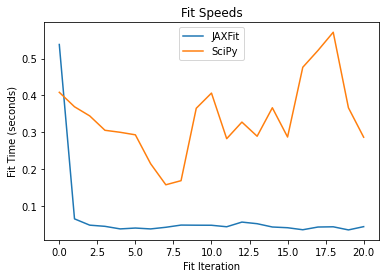

In [12]:
import jax.numpy as jnp
  
length = 3 * 10**5
x = np.linspace(0, 10, length)

jcf = CurveFit()
jax_fit_times = []
scipy_fit_times = []
nsamples = 21

all_params = np.random.random(size=(nsamples, 4))

for i in range(nsamples):
  params = get_random_parameters()
  y = quad_exp(x, *all_params[i]) + np.random.normal(0, 0.2, size=length)

  # fit the data
  start_time = time.time()
  popt1, pcov1 = jcf.curve_fit(quad_exp, x, y, p0=(.5,.5,.5,.5))
  jax_fit_times.append(time.time() - start_time)

  start_time = time.time()
  popt2, pcov2 = curve_fit(quad_exp, x, y, p0=(.5,.5,.5,.5))
  scipy_fit_times.append(time.time() - start_time)

plt.figure()
plt.title('Fit Speeds')
plt.plot(jax_fit_times, label='JAXFit')
plt.plot(scipy_fit_times, label='SciPy')
plt.legend()
plt.xlabel('Fit Iteration')
plt.ylabel('Fit Time (seconds)')


And we see it's so much faster minus the first fit in which tracing is occuring. Thus, by avoiding retracing and utilizing the GPU we get super fast fitting.